# Training
This notebook trains the model with 3 fold cross validation.

In [1]:
from codecarbon import EmissionsTracker
import logging
output_directory = "/fp/homes01/u01/ec-krimhau/thesis_code/"

tracker = EmissionsTracker(output_dir=output_directory)
tracker.start()

[codecarbon INFO @ 08:33:08] [setup] RAM Tracking...
[codecarbon INFO @ 08:33:08] [setup] GPU Tracking...
[codecarbon INFO @ 08:33:08] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 08:33:08] [setup] CPU Tracking...
[codecarbon WARNING @ 08:33:08] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 08:33:11] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 08:33:11] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor
[codecarbon INFO @ 08:33:11] >>> Tracker's metadata:
[codecarbon INFO @ 08:33:11]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 08:33:11]   Python version: 3.11.3
[codecarbon INFO @ 08:33:11]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 08:33:11]   Available RAM : 256.000 GB
[codecarbon INFO @ 08:33:11]   CPU count: 24
[codecarbon INFO @ 08:33:11]   CPU model: AMD EPYC 7642 48-Core Processor
[codecarbon 

[codecarbon WARNING @ 07:53:24] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.


[codecarbon INFO @ 07:53:24] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor


[codecarbon INFO @ 07:53:24] >>> Tracker's metadata:


[codecarbon INFO @ 07:53:24]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34


[codecarbon INFO @ 07:53:24]   Python version: 3.11.3


[codecarbon INFO @ 07:53:24]   CodeCarbon version: 2.3.4


[codecarbon INFO @ 07:53:24]   Available RAM : 256.000 GB


[codecarbon INFO @ 07:53:24]   CPU count: 24


[codecarbon INFO @ 07:53:24]   CPU model: AMD EPYC 7642 48-Core Processor


[codecarbon INFO @ 07:53:24]   GPU count: 1


[codecarbon INFO @ 07:53:24]   GPU model: 1 x NVIDIA A100-PCIE-40GB


In [2]:
logging.getLogger('codecarbon').setLevel(logging.WARNING)

# Imports and setup

In [3]:
import sys
# Need this to load the packages correct in Fox ml nodes.
sys.path.append("/fp/homes01/u01/ec-krimhau/.local/lib/python3.11/site-packages")

In [4]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import wandb

In [5]:
# Load .env file
%load_ext dotenv
%dotenv /fp/homes01/u01/ec-krimhau/thesis_code/.env

In [6]:
# Get wandb api key from .env file
wandb_api_key = os.getenv('WANDB_API_KEY')
# Login to wandb to track results
wandb.login(key = wandb_api_key) # API key

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: haugerud-kristian (krimhau). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /fp/homes01/u01/ec-krimhau/.netrc


True

In [7]:
# Function to generate a unique random identifier for experiment tracking.
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = "a5c0f63nf2h8"
print(HASH_NAME)

a5c0f63nf2h8


In [8]:
# Config for the model
CONFIG = {"seed": 42,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [9]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [10]:
# Splits the data into train and test. Validation is done using KFold.
def train_test_split(df, train_percent=.85, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [11]:
import pandas as pd
path_to_files = "//fp/projects01/ec307/ec-krimhau/jira_datasets/"
file_name = "highest_vs_lowest_balanced_jira.csv"
!ls /fp/projects01/ec307/ec-krimhau/jira_datasets

highest_high_vs_low_lowest_balanced_jira.csv	high_highest_vs_rest
highest_vs_lowest_balanced_jira.csv		high_vs_rest
highest_vs_rest_min_len_25th_balanced_jira.csv	jira_clean_with_all_cols.csv


In [12]:
priority_df = pd.read_csv(f"{path_to_files}/{file_name}")
priority_df

,label,text
0,0,testing on version discovered test case does a...
1,1,description this is an issue found when use co...
2,0,description since unixtimestamp udf was deprec...
3,0,in programmming guides most algos in ml have l...
4,1,creation of system eventqueue was commented ou...
...,...,...
64981,1,seems to have introduced a bug because of whic...
64982,1,copying s comment from mailing list on head wi...
64983,0,add ability to merge multiple listsmapssets th...
64984,0,rename asterixjavaclient to asterixtestclient


In [13]:
# Check if NaN
priority_df.isna().any()

label    False
text     False
dtype: bool

In [14]:
priority_df

,label,text
0,0,testing on version discovered test case does a...
1,1,description this is an issue found when use co...
2,0,description since unixtimestamp udf was deprec...
3,0,in programmming guides most algos in ml have l...
4,1,creation of system eventqueue was commented ou...
...,...,...
64981,1,seems to have introduced a bug because of whic...
64982,1,copying s comment from mailing list on head wi...
64983,0,add ability to merge multiple listsmapssets th...
64984,0,rename asterixjavaclient to asterixtestclient


In [15]:
priority_df["label"].value_counts()

label
0    32493
1    32493
Name: count, dtype: int64

In [16]:
train_hp_df , test_hp_df = train_test_split(priority_df)

In [17]:
df = train_hp_df
df

,label,text
23779,0,they should return the tostring of the underly...
63455,1,the commit seems to have reverted multiple imp...
6201,0,after the release the community agreed on jump...
20041,1,we are performing functional testing of sakai ...
43037,1,there are two problems in in a kerberized clus...
...,...,...
28902,0,it would be nice to also ignore jcraft keepali...
62472,1,mockups for the screens are available at the f...
29992,1,in the version reported user cant access error...
4137,0,there is a typo on the website abouthtml the w...


In [18]:
df.reset_index(inplace = True)
df = df.drop('index', axis=1)
df

,label,text
0,0,they should return the tostring of the underly...
1,1,the commit seems to have reverted multiple imp...
2,0,after the release the community agreed on jump...
3,1,we are performing functional testing of sakai ...
4,1,there are two problems in in a kerberized clus...
...,...,...
55233,0,it would be nice to also ignore jcraft keepali...
55234,1,mockups for the screens are available at the f...
55235,1,in the version reported user cant access error...
55236,0,there is a typo on the website abouthtml the w...


In [19]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [20]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      1        9346
       0        9067
1      0        9270
       1        9143
2      0        9297
       1        9115
Name: count, dtype: int64

In [21]:
df

,label,text,kfold
0,0,they should return the tostring of the underly...,2
1,1,the commit seems to have reverted multiple imp...,2
2,0,after the release the community agreed on jump...,1
3,1,we are performing functional testing of sakai ...,2
4,1,there are two problems in in a kerberized clus...,0
...,...,...,...
55233,0,it would be nice to also ignore jcraft keepali...,1
55234,1,mockups for the screens are available at the f...,0
55235,1,in the version reported user cant access error...,1
55236,0,there is a typo on the website abouthtml the w...,2


In [22]:
class HP_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [23]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [24]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [25]:
class HP_Model(nn.Module):
    def __init__(self, model_name):
        super(HP_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [26]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [27]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [29]:
def all_classification_report(y_true, y_pred, target_names = ['Non_HP', 'HP'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names = target_names, digits=4))
    
    accuracy =round(accuracy_score(y_true, y_pred),4)
    print("Accuracy =",  accuracy)
    f1score = round(f1_score(y_true, y_pred),4)
    print("F1_score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non_HP', 'HP'])
    ax.yaxis.set_ticklabels(['Non_HP', 'HP'])
    
    return  accuracy , f1score
    
    

In [30]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [31]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [32]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = HP_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = HP_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [33]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

<h2> Testing Inference </h2>


In [34]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [35]:
test_df = test_hp_df

In [36]:
test_df

,label,text
59198,1,xml examples of configuration are not correct ...
4150,1,the url field for web content is missing durin...
39236,1,this bug was imported from another system and ...
14017,0,here is the full license statement for all its...
49731,0,of course i had to make some content changes t...
...,...,...
62570,0,it seems a bit unfair that only allows select ...
38158,0,cxf parent was changed in to contain all the c...
860,1,this bug was imported from another system and ...
15795,1,when a gc run is cancelled the subsequent run ...


In [37]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [38]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = HP_Model(CONFIG['model_name'])

In [39]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [40]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [41]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████| 610/610 [03:01<00:00,  3.35it/s]


Fold 1


100%|██████████| 610/610 [03:01<00:00,  3.36it/s]


Fold 2


100%|██████████| 610/610 [03:00<00:00,  3.37it/s]


  7%|███████▎                                                                                              | 44/610 [00:04<00:55, 10.19it/s]

  8%|███████▋                                                                                              | 46/610 [00:04<01:06,  8.44it/s]

  8%|███████▊                                                                                              | 47/610 [00:05<01:05,  8.62it/s]

  8%|████████▏                                                                                             | 49/610 [00:05<01:01,  9.17it/s]

  8%|████████▌                                                                                             | 51/610 [00:05<00:58,  9.56it/s]

  9%|████████▋                                                                                             | 52/610 [00:05<01:03,  8.78it/s]

  9%|█████████                                                                                             | 54/610 [00:05<00:54, 10.23it/s]

  9%|█████████▎                                                                                            | 56/610 [00:05<00:54, 10.22it/s]

 10%|█████████▋                                                                                            | 58/610 [00:06<00:58,  9.50it/s]

 10%|█████████▊                                                                                            | 59/610 [00:06<01:05,  8.39it/s]

 10%|██████████                                                                                            | 60/610 [00:06<01:12,  7.57it/s]

 10%|██████████▏                                                                                           | 61/610 [00:06<01:18,  6.98it/s]

 10%|██████████▌                                                                                           | 63/610 [00:06<01:02,  8.70it/s]

 10%|██████████▋                                                                                           | 64/610 [00:06<01:01,  8.86it/s]

 11%|██████████▊                                                                                           | 65/610 [00:07<01:10,  7.74it/s]

 11%|███████████                                                                                           | 66/610 [00:07<01:10,  7.74it/s]

 11%|███████████▎                                                                                          | 68/610 [00:07<00:58,  9.30it/s]

 11%|███████████▋                                                                                          | 70/610 [00:07<01:01,  8.80it/s]

 12%|███████████▊                                                                                          | 71/610 [00:07<01:01,  8.80it/s]

 12%|████████████▏                                                                                         | 73/610 [00:07<01:03,  8.44it/s]

 12%|████████████▎                                                                                         | 74/610 [00:08<01:08,  7.84it/s]

 12%|████████████▋                                                                                         | 76/610 [00:08<01:07,  7.86it/s]

 13%|████████████▉                                                                                         | 77/610 [00:08<01:06,  8.03it/s]

 13%|█████████████▏                                                                                        | 79/610 [00:08<00:56,  9.44it/s]

 13%|█████████████▌                                                                                        | 81/610 [00:08<00:56,  9.41it/s]

 14%|█████████████▉                                                                                        | 83/610 [00:09<00:51, 10.32it/s]

 14%|██████████████▏                                                                                       | 85/610 [00:09<00:57,  9.09it/s]

 14%|██████████████▍                                                                                       | 86/610 [00:09<00:57,  9.05it/s]

 14%|██████████████▌                                                                                       | 87/610 [00:09<00:58,  8.99it/s]

 15%|██████████████▉                                                                                       | 89/610 [00:09<00:50, 10.34it/s]

 15%|███████████████▏                                                                                      | 91/610 [00:09<00:56,  9.20it/s]

 15%|███████████████▌                                                                                      | 93/610 [00:10<00:52,  9.87it/s]

 16%|███████████████▉                                                                                      | 95/610 [00:10<01:00,  8.55it/s]

 16%|████████████████▏                                                                                     | 97/610 [00:10<00:54,  9.38it/s]

 16%|████████████████▌                                                                                     | 99/610 [00:10<00:50, 10.20it/s]

 17%|████████████████▋                                                                                    | 101/610 [00:11<00:54,  9.37it/s]

 17%|████████████████▉                                                                                    | 102/610 [00:11<00:58,  8.64it/s]

 17%|█████████████████                                                                                    | 103/610 [00:11<01:01,  8.21it/s]

 17%|█████████████████▍                                                                                   | 105/610 [00:11<01:03,  8.00it/s]

 18%|█████████████████▋                                                                                   | 107/610 [00:11<01:00,  8.32it/s]

 18%|█████████████████▉                                                                                   | 108/610 [00:11<01:01,  8.20it/s]

 18%|██████████████████                                                                                   | 109/610 [00:12<01:07,  7.40it/s]

 18%|██████████████████▏                                                                                  | 110/610 [00:12<01:12,  6.85it/s]

 18%|██████████████████▌                                                                                  | 112/610 [00:12<00:55,  8.93it/s]

 19%|██████████████████▋                                                                                  | 113/610 [00:12<00:54,  9.08it/s]

 19%|██████████████████▉                                                                                  | 114/610 [00:12<00:55,  8.95it/s]

 19%|███████████████████▏                                                                                 | 116/610 [00:12<00:57,  8.62it/s]

 19%|███████████████████▌                                                                                 | 118/610 [00:13<00:53,  9.16it/s]

 20%|███████████████████▊                                                                                 | 120/610 [00:13<00:51,  9.58it/s]

 20%|████████████████████▏                                                                                | 122/610 [00:13<00:45, 10.74it/s]

 20%|████████████████████▌                                                                                | 124/610 [00:13<00:43, 11.15it/s]

 21%|████████████████████▊                                                                                | 126/610 [00:13<00:49,  9.75it/s]

 21%|█████████████████████▏                                                                               | 128/610 [00:14<00:51,  9.38it/s]

 21%|█████████████████████▌                                                                               | 130/610 [00:14<00:46, 10.29it/s]

 22%|█████████████████████▊                                                                               | 132/610 [00:14<00:51,  9.29it/s]

 22%|██████████████████████                                                                               | 133/610 [00:14<00:55,  8.55it/s]

 22%|██████████████████████▎                                                                              | 135/610 [00:14<00:48,  9.78it/s]

 22%|██████████████████████▋                                                                              | 137/610 [00:15<00:53,  8.79it/s]

 23%|██████████████████████▊                                                                              | 138/610 [00:15<00:56,  8.36it/s]

 23%|███████████████████████                                                                              | 139/610 [00:15<01:02,  7.54it/s]

 23%|███████████████████████▎                                                                             | 141/610 [00:15<00:50,  9.20it/s]

 23%|███████████████████████▌                                                                             | 142/610 [00:15<00:56,  8.31it/s]

 23%|███████████████████████▋                                                                             | 143/610 [00:15<00:55,  8.40it/s]

 24%|████████████████████████                                                                             | 145/610 [00:15<00:46,  9.96it/s]

 24%|████████████████████████▎                                                                            | 147/610 [00:16<00:50,  9.15it/s]

 24%|████████████████████████▌                                                                            | 148/610 [00:16<00:57,  8.07it/s]

 24%|████████████████████████▋                                                                            | 149/610 [00:16<01:03,  7.30it/s]

 25%|████████████████████████▊                                                                            | 150/610 [00:16<00:59,  7.79it/s]

 25%|█████████████████████████                                                                            | 151/610 [00:16<00:56,  8.19it/s]

 25%|█████████████████████████▎                                                                           | 153/610 [00:16<00:47,  9.55it/s]

 25%|█████████████████████████▋                                                                           | 155/610 [00:17<00:50,  9.03it/s]

 26%|█████████████████████████▉                                                                           | 157/610 [00:17<00:51,  8.74it/s]

 26%|██████████████████████████▎                                                                          | 159/610 [00:17<00:54,  8.22it/s]

 26%|██████████████████████████▍                                                                          | 160/610 [00:17<00:56,  7.99it/s]

 26%|██████████████████████████▋                                                                          | 161/610 [00:17<01:01,  7.29it/s]

 27%|██████████████████████████▉                                                                          | 163/610 [00:18<00:55,  8.05it/s]

 27%|███████████████████████████▏                                                                         | 164/610 [00:18<01:00,  7.34it/s]

 27%|███████████████████████████▍                                                                         | 166/610 [00:18<00:58,  7.55it/s]

 27%|███████████████████████████▋                                                                         | 167/610 [00:18<00:56,  7.78it/s]

 28%|███████████████████████████▊                                                                         | 168/610 [00:18<01:02,  7.10it/s]

 28%|████████████████████████████▏                                                                        | 170/610 [00:19<00:53,  8.16it/s]

 28%|████████████████████████████▎                                                                        | 171/610 [00:19<00:54,  8.06it/s]

 28%|████████████████████████████▍                                                                        | 172/610 [00:19<00:58,  7.51it/s]

 29%|████████████████████████████▊                                                                        | 174/610 [00:19<00:53,  8.16it/s]

 29%|█████████████████████████████▏                                                                       | 176/610 [00:19<00:49,  8.71it/s]

 29%|█████████████████████████████▎                                                                       | 177/610 [00:20<00:55,  7.79it/s]

 29%|█████████████████████████████▋                                                                       | 179/610 [00:20<00:46,  9.17it/s]

 30%|█████████████████████████████▊                                                                       | 180/610 [00:20<00:53,  8.06it/s]

 30%|██████████████████████████████▏                                                                      | 182/610 [00:20<00:46,  9.23it/s]

 30%|██████████████████████████████▎                                                                      | 183/610 [00:20<00:49,  8.65it/s]

 30%|██████████████████████████████▍                                                                      | 184/610 [00:20<00:55,  7.65it/s]

 30%|██████████████████████████████▋                                                                      | 185/610 [00:20<00:59,  7.17it/s]

 30%|██████████████████████████████▊                                                                      | 186/610 [00:21<01:03,  6.65it/s]

 31%|███████████████████████████████▏                                                                     | 188/610 [00:21<00:54,  7.74it/s]

 31%|███████████████████████████████▍                                                                     | 190/610 [00:21<00:51,  8.21it/s]

 31%|███████████████████████████████▌                                                                     | 191/610 [00:21<00:53,  7.90it/s]

 31%|███████████████████████████████▊                                                                     | 192/610 [00:21<00:52,  7.90it/s]

 32%|███████████████████████████████▉                                                                     | 193/610 [00:22<00:58,  7.14it/s]

 32%|████████████████████████████████                                                                     | 194/610 [00:22<01:02,  6.64it/s]

 32%|████████████████████████████████▍                                                                    | 196/610 [00:22<00:51,  8.01it/s]

 32%|████████████████████████████████▌                                                                    | 197/610 [00:22<00:57,  7.24it/s]

 33%|████████████████████████████████▉                                                                    | 199/610 [00:22<00:44,  9.27it/s]

 33%|█████████████████████████████████▎                                                                   | 201/610 [00:22<00:40, 10.02it/s]

 33%|█████████████████████████████████▌                                                                   | 203/610 [00:23<00:41,  9.76it/s]

 34%|█████████████████████████████████▉                                                                   | 205/610 [00:23<00:36, 11.00it/s]

 34%|██████████████████████████████████▎                                                                  | 207/610 [00:23<00:33, 11.93it/s]

 34%|██████████████████████████████████▌                                                                  | 209/610 [00:23<00:31, 12.66it/s]

 35%|██████████████████████████████████▉                                                                  | 211/610 [00:23<00:39, 10.09it/s]

 35%|███████████████████████████████████▎                                                                 | 213/610 [00:24<00:44,  8.95it/s]

 35%|███████████████████████████████████▌                                                                 | 215/610 [00:24<00:42,  9.38it/s]

 36%|███████████████████████████████████▉                                                                 | 217/610 [00:24<00:38, 10.17it/s]

 36%|████████████████████████████████████▎                                                                | 219/610 [00:24<00:41,  9.48it/s]

 36%|████████████████████████████████████▌                                                                | 221/610 [00:25<00:49,  7.81it/s]

 36%|████████████████████████████████████▊                                                                | 222/610 [00:25<00:50,  7.64it/s]

 37%|████████████████████████████████████▉                                                                | 223/610 [00:25<00:54,  7.09it/s]

 37%|█████████████████████████████████████                                                                | 224/610 [00:25<00:57,  6.67it/s]

 37%|█████████████████████████████████████▎                                                               | 225/610 [00:25<00:59,  6.44it/s]

 37%|█████████████████████████████████████▌                                                               | 227/610 [00:25<00:46,  8.23it/s]

 38%|█████████████████████████████████████▉                                                               | 229/610 [00:26<00:44,  8.61it/s]

 38%|██████████████████████████████████████                                                               | 230/610 [00:26<00:45,  8.30it/s]

 38%|██████████████████████████████████████▍                                                              | 232/610 [00:26<00:39,  9.66it/s]

 38%|██████████████████████████████████████▋                                                              | 234/610 [00:26<00:41,  9.17it/s]

 39%|███████████████████████████████████████                                                              | 236/610 [00:26<00:37, 10.10it/s]

 39%|███████████████████████████████████████▍                                                             | 238/610 [00:26<00:31, 11.70it/s]

 39%|███████████████████████████████████████▋                                                             | 240/610 [00:27<00:38,  9.65it/s]

 40%|████████████████████████████████████████                                                             | 242/610 [00:27<00:43,  8.37it/s]

 40%|████████████████████████████████████████▏                                                            | 243/610 [00:27<00:48,  7.64it/s]

 40%|████████████████████████████████████████▍                                                            | 244/610 [00:27<00:46,  7.88it/s]

 40%|████████████████████████████████████████▌                                                            | 245/610 [00:27<00:50,  7.19it/s]

 40%|████████████████████████████████████████▉                                                            | 247/610 [00:28<00:41,  8.80it/s]

 41%|█████████████████████████████████████████▏                                                           | 249/610 [00:28<00:36,  9.79it/s]

 41%|█████████████████████████████████████████▌                                                           | 251/610 [00:28<00:46,  7.76it/s]

 41%|█████████████████████████████████████████▉                                                           | 253/610 [00:28<00:38,  9.36it/s]

 42%|██████████████████████████████████████████▏                                                          | 255/610 [00:28<00:36,  9.73it/s]

 42%|██████████████████████████████████████████▌                                                          | 257/610 [00:29<00:32, 11.00it/s]

 42%|██████████████████████████████████████████▉                                                          | 259/610 [00:29<00:38,  9.09it/s]

 43%|███████████████████████████████████████████▏                                                         | 261/610 [00:29<00:35,  9.90it/s]

 43%|███████████████████████████████████████████▌                                                         | 263/610 [00:29<00:36,  9.61it/s]

 43%|███████████████████████████████████████████▉                                                         | 265/610 [00:29<00:31, 11.07it/s]

 44%|████████████████████████████████████████████▏                                                        | 267/610 [00:30<00:31, 10.87it/s]

 44%|████████████████████████████████████████████▌                                                        | 269/610 [00:30<00:40,  8.40it/s]

 44%|████████████████████████████████████████████▋                                                        | 270/610 [00:30<00:44,  7.69it/s]

 45%|█████████████████████████████████████████████                                                        | 272/610 [00:30<00:38,  8.77it/s]

 45%|█████████████████████████████████████████████▏                                                       | 273/610 [00:30<00:42,  7.88it/s]

 45%|█████████████████████████████████████████████▌                                                       | 275/610 [00:31<00:36,  9.12it/s]

 45%|█████████████████████████████████████████████▋                                                       | 276/610 [00:31<00:41,  8.06it/s]

 45%|█████████████████████████████████████████████▊                                                       | 277/610 [00:31<00:45,  7.30it/s]

 46%|██████████████████████████████████████████████▏                                                      | 279/610 [00:31<00:40,  8.10it/s]

 46%|██████████████████████████████████████████████▎                                                      | 280/610 [00:31<00:44,  7.36it/s]

 46%|██████████████████████████████████████████████▌                                                      | 281/610 [00:32<00:48,  6.80it/s]

 46%|██████████████████████████████████████████████▋                                                      | 282/610 [00:32<00:51,  6.43it/s]

 47%|███████████████████████████████████████████████                                                      | 284/610 [00:32<00:46,  7.06it/s]

 47%|███████████████████████████████████████████████▎                                                     | 286/610 [00:32<00:42,  7.62it/s]

 47%|███████████████████████████████████████████████▌                                                     | 287/610 [00:32<00:45,  7.04it/s]

 47%|███████████████████████████████████████████████▊                                                     | 289/610 [00:33<00:37,  8.56it/s]

 48%|████████████████████████████████████████████████                                                     | 290/610 [00:33<00:41,  7.67it/s]

 48%|████████████████████████████████████████████████▏                                                    | 291/610 [00:33<00:45,  7.04it/s]

 48%|████████████████████████████████████████████████▎                                                    | 292/610 [00:33<00:48,  6.59it/s]

 48%|████████████████████████████████████████████████▌                                                    | 293/610 [00:33<00:50,  6.27it/s]

 48%|████████████████████████████████████████████████▋                                                    | 294/610 [00:33<00:52,  6.05it/s]

 49%|█████████████████████████████████████████████████                                                    | 296/610 [00:34<00:38,  8.18it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 298/610 [00:34<00:39,  7.81it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 300/610 [00:34<00:37,  8.23it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 301/610 [00:34<00:38,  8.04it/s]

 50%|██████████████████████████████████████████████████                                                   | 302/610 [00:34<00:42,  7.29it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 303/610 [00:34<00:41,  7.40it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 305/610 [00:35<00:38,  7.94it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 307/610 [00:35<00:32,  9.24it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 308/610 [00:35<00:37,  8.11it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 309/610 [00:35<00:39,  7.53it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 310/610 [00:35<00:43,  6.90it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 311/610 [00:36<00:46,  6.47it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 312/610 [00:36<00:46,  6.44it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 314/610 [00:36<00:36,  8.10it/s]

 52%|████████████████████████████████████████████████████▎                                                | 316/610 [00:36<00:30,  9.79it/s]

 52%|████████████████████████████████████████████████████▋                                                | 318/610 [00:36<00:35,  8.22it/s]

 52%|████████████████████████████████████████████████████▉                                                | 320/610 [00:37<00:36,  8.00it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 322/610 [00:37<00:35,  8.07it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 324/610 [00:37<00:32,  8.88it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 326/610 [00:37<00:31,  9.10it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 328/610 [00:37<00:28, 10.04it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 330/610 [00:38<00:27, 10.32it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 332/610 [00:38<00:30,  8.98it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 334/610 [00:38<00:31,  8.79it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 335/610 [00:38<00:31,  8.71it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 337/610 [00:38<00:29,  9.24it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 339/610 [00:39<00:29,  9.08it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 340/610 [00:39<00:29,  9.16it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 342/610 [00:39<00:27,  9.78it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 344/610 [00:39<00:28,  9.21it/s]

 57%|█████████████████████████████████████████████████████████                                            | 345/610 [00:39<00:31,  8.30it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 346/610 [00:39<00:32,  8.24it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 348/610 [00:40<00:27,  9.67it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 349/610 [00:40<00:31,  8.33it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 350/610 [00:40<00:32,  7.90it/s]

 58%|██████████████████████████████████████████████████████████                                           | 351/610 [00:40<00:33,  7.65it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 352/610 [00:40<00:32,  8.03it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 353/610 [00:40<00:36,  7.11it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 354/610 [00:41<00:34,  7.33it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 356/610 [00:41<00:26,  9.74it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 358/610 [00:41<00:29,  8.46it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 359/610 [00:41<00:32,  7.83it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 360/610 [00:41<00:35,  7.10it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 361/610 [00:41<00:37,  6.61it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 362/610 [00:42<00:39,  6.27it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 364/610 [00:42<00:35,  6.89it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 366/610 [00:42<00:29,  8.19it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 367/610 [00:42<00:32,  7.42it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 368/610 [00:42<00:35,  6.85it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 370/610 [00:43<00:33,  7.12it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 372/610 [00:43<00:31,  7.47it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 373/610 [00:43<00:34,  6.96it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 374/610 [00:43<00:35,  6.56it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 375/610 [00:43<00:33,  6.99it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 376/610 [00:44<00:35,  6.53it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 377/610 [00:44<00:37,  6.21it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 379/610 [00:44<00:31,  7.28it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 381/610 [00:44<00:27,  8.32it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 382/610 [00:44<00:30,  7.49it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 384/610 [00:45<00:30,  7.37it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 385/610 [00:45<00:32,  7.02it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 386/610 [00:45<00:33,  6.60it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 387/610 [00:45<00:32,  6.90it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 389/610 [00:45<00:25,  8.53it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 390/610 [00:45<00:26,  8.37it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 392/610 [00:46<00:27,  7.89it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 394/610 [00:46<00:25,  8.43it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 395/610 [00:46<00:28,  7.60it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 396/610 [00:46<00:28,  7.48it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 398/610 [00:46<00:24,  8.75it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 399/610 [00:46<00:25,  8.26it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 400/610 [00:47<00:28,  7.37it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 402/610 [00:47<00:26,  7.89it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 403/610 [00:47<00:28,  7.37it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 404/610 [00:47<00:27,  7.36it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 405/610 [00:47<00:30,  6.77it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 407/610 [00:48<00:28,  7.08it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 408/610 [00:48<00:30,  6.63it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 410/610 [00:48<00:25,  7.77it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 411/610 [00:48<00:26,  7.54it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 413/610 [00:48<00:22,  8.68it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 414/610 [00:48<00:22,  8.81it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 416/610 [00:49<00:23,  8.13it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 417/610 [00:49<00:26,  7.37it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 418/610 [00:49<00:28,  6.81it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 419/610 [00:49<00:29,  6.57it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 420/610 [00:49<00:27,  6.84it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 422/610 [00:50<00:20,  9.10it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                              | 424/610 [00:50<00:20,  8.97it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 425/610 [00:50<00:23,  7.90it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 427/610 [00:50<00:18,  9.77it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 429/610 [00:50<00:20,  8.99it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 430/610 [00:50<00:22,  7.97it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 431/610 [00:51<00:23,  7.53it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 433/610 [00:51<00:23,  7.68it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 434/610 [00:51<00:24,  7.06it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 435/610 [00:51<00:24,  7.06it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 436/610 [00:51<00:26,  6.59it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 438/610 [00:52<00:20,  8.56it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 439/610 [00:52<00:20,  8.53it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 440/610 [00:52<00:22,  7.50it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 441/610 [00:52<00:24,  6.84it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 442/610 [00:52<00:22,  7.43it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 443/610 [00:52<00:22,  7.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 445/610 [00:53<00:21,  7.80it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 447/610 [00:53<00:21,  7.58it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 448/610 [00:53<00:22,  7.21it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 449/610 [00:53<00:24,  6.71it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 451/610 [00:53<00:21,  7.39it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 452/610 [00:53<00:20,  7.64it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 453/610 [00:54<00:20,  7.52it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 455/610 [00:54<00:20,  7.52it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 456/610 [00:54<00:21,  7.06it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 457/610 [00:54<00:20,  7.48it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 458/610 [00:54<00:22,  6.84it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 459/610 [00:54<00:21,  7.19it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 460/610 [00:55<00:22,  6.62it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 461/610 [00:55<00:23,  6.25it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 463/610 [00:55<00:18,  7.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 464/610 [00:55<00:18,  7.82it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 466/610 [00:55<00:16,  8.90it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 467/610 [00:55<00:17,  8.11it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 468/610 [00:56<00:17,  8.18it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 470/610 [00:56<00:15,  8.81it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 472/610 [00:56<00:14,  9.85it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 474/610 [00:56<00:13, 10.21it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 476/610 [00:56<00:13,  9.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 478/610 [00:56<00:11, 11.06it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 480/610 [00:57<00:13,  9.67it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 482/610 [00:57<00:14,  8.92it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 484/610 [00:57<00:12,  9.95it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 486/610 [00:58<00:15,  7.98it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 488/610 [00:58<00:15,  8.05it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 489/610 [00:58<00:16,  7.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 490/610 [00:58<00:17,  7.02it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 491/610 [00:58<00:17,  6.80it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 493/610 [00:59<00:16,  7.25it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 495/610 [00:59<00:13,  8.62it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 496/610 [00:59<00:13,  8.76it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 497/610 [00:59<00:13,  8.29it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 499/610 [00:59<00:11, 10.05it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 501/610 [00:59<00:14,  7.75it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 503/610 [01:00<00:13,  7.71it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 504/610 [01:00<00:14,  7.15it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 506/610 [01:00<00:12,  8.35it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 507/610 [01:00<00:12,  8.53it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 509/610 [01:00<00:09, 10.23it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 511/610 [01:00<00:09, 10.65it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 513/610 [01:01<00:08, 11.79it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 515/610 [01:01<00:09, 10.53it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 517/610 [01:01<00:08, 10.96it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 519/610 [01:01<00:10,  8.38it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 520/610 [01:02<00:11,  7.65it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 522/610 [01:02<00:09,  8.86it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 523/610 [01:02<00:09,  8.95it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 524/610 [01:02<00:10,  7.87it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 526/610 [01:02<00:10,  7.97it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 528/610 [01:02<00:09,  9.03it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 530/610 [01:03<00:08,  8.95it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 531/610 [01:03<00:09,  8.48it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 532/610 [01:03<00:09,  8.13it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 533/610 [01:03<00:10,  7.31it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 534/610 [01:03<00:10,  7.47it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 535/610 [01:03<00:11,  6.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 536/610 [01:04<00:10,  7.38it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 538/610 [01:04<00:09,  7.46it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 539/610 [01:04<00:09,  7.32it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 541/610 [01:04<00:07,  9.23it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 542/610 [01:04<00:07,  9.02it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 543/610 [01:04<00:08,  7.80it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 545/610 [01:05<00:07,  8.71it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 546/610 [01:05<00:07,  8.84it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 548/610 [01:05<00:07,  8.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 549/610 [01:05<00:07,  7.77it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 550/610 [01:05<00:07,  8.12it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 552/610 [01:05<00:07,  8.02it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 553/610 [01:06<00:07,  7.25it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 554/610 [01:06<00:08,  6.72it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 555/610 [01:06<00:08,  6.35it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 556/610 [01:06<00:08,  6.47it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 557/610 [01:06<00:07,  7.14it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 559/610 [01:06<00:06,  7.64it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 560/610 [01:07<00:07,  6.99it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 561/610 [01:07<00:07,  6.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 563/610 [01:07<00:05,  8.80it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 565/610 [01:07<00:04, 11.12it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 567/610 [01:07<00:05,  8.19it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 569/610 [01:08<00:04,  8.62it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 571/610 [01:08<00:03,  9.89it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 573/610 [01:08<00:04,  8.37it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 574/610 [01:08<00:04,  7.63it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 575/610 [01:08<00:04,  7.78it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/610 [01:09<00:04,  7.10it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 578/610 [01:09<00:03,  9.16it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 580/610 [01:09<00:04,  7.37it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 582/610 [01:09<00:03,  7.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 583/610 [01:09<00:03,  7.02it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 584/610 [01:10<00:03,  6.78it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 586/610 [01:10<00:02,  8.11it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 588/610 [01:10<00:02,  8.34it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 590/610 [01:10<00:02,  8.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 592/610 [01:10<00:01, 10.33it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 594/610 [01:11<00:01,  8.41it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 595/610 [01:11<00:01,  8.39it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 596/610 [01:11<00:01,  8.08it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 597/610 [01:11<00:01,  7.29it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 598/610 [01:11<00:01,  7.38it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 599/610 [01:11<00:01,  7.63it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 601/610 [01:12<00:00,  9.03it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 602/610 [01:12<00:00,  9.10it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 603/610 [01:12<00:00,  8.01it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 604/610 [01:12<00:00,  7.77it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 605/610 [01:12<00:00,  6.98it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 606/610 [01:12<00:00,  6.47it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 607/610 [01:13<00:00,  6.15it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 609/610 [01:13<00:00,  8.14it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 610/610 [01:13<00:00,  8.33it/s]

Fold 1


  0%|                                                                                                               | 0/610 [00:00<?, ?it/s]

  0%|▎                                                                                                      | 2/610 [00:00<01:20,  7.55it/s]

  1%|▋                                                                                                      | 4/610 [00:00<00:59, 10.10it/s]

  1%|█                                                                                                      | 6/610 [00:00<01:04,  9.33it/s]

  1%|█▎                                                                                                     | 8/610 [00:00<00:56, 10.74it/s]

  2%|█▋                                                                                                    | 10/610 [00:01<01:02,  9.67it/s]

  2%|██                                                                                                    | 12/610 [00:01<00:59, 10.09it/s]

  2%|██▎                                                                                                   | 14/610 [00:01<01:05,  9.04it/s]

  3%|██▋                                                                                                   | 16/610 [00:01<00:59, 10.05it/s]

  3%|███                                                                                                   | 18/610 [00:01<00:56, 10.46it/s]

  3%|███▎                                                                                                  | 20/610 [00:02<01:07,  8.80it/s]

  3%|███▌                                                                                                  | 21/610 [00:02<01:07,  8.72it/s]

  4%|███▊                                                                                                  | 23/610 [00:02<01:03,  9.25it/s]

  4%|████                                                                                                  | 24/610 [00:02<01:05,  8.95it/s]

  4%|████▏                                                                                                 | 25/610 [00:02<01:14,  7.86it/s]

  4%|████▎                                                                                                 | 26/610 [00:02<01:11,  8.15it/s]

  5%|████▋                                                                                                 | 28/610 [00:03<01:06,  8.78it/s]

  5%|████▊                                                                                                 | 29/610 [00:03<01:15,  7.74it/s]

  5%|█████▏                                                                                                | 31/610 [00:03<01:03,  9.19it/s]

  5%|█████▎                                                                                                | 32/610 [00:03<01:06,  8.63it/s]

  6%|█████▋                                                                                                | 34/610 [00:03<00:56, 10.22it/s]

  6%|██████                                                                                                | 36/610 [00:03<00:50, 11.34it/s]

  6%|██████▎                                                                                               | 38/610 [00:04<00:53, 10.76it/s]

  7%|██████▋                                                                                               | 40/610 [00:04<00:48, 11.79it/s]

  7%|███████                                                                                               | 42/610 [00:04<00:50, 11.16it/s]

  7%|███████▎                                                                                              | 44/610 [00:04<00:55, 10.14it/s]

  8%|███████▋                                                                                              | 46/610 [00:04<01:07,  8.38it/s]

  8%|███████▊                                                                                              | 47/610 [00:05<01:05,  8.55it/s]

  8%|████████▏                                                                                             | 49/610 [00:05<01:01,  9.12it/s]

  8%|████████▌                                                                                             | 51/610 [00:05<00:58,  9.52it/s]

  9%|████████▋                                                                                             | 52/610 [00:05<01:04,  8.71it/s]

  9%|█████████                                                                                             | 54/610 [00:05<00:54, 10.16it/s]

  9%|█████████▎                                                                                            | 56/610 [00:05<00:54, 10.14it/s]

 10%|█████████▋                                                                                            | 58/610 [00:06<00:58,  9.45it/s]

 10%|█████████▊                                                                                            | 59/610 [00:06<01:06,  8.33it/s]

 10%|██████████                                                                                            | 60/610 [00:06<01:13,  7.50it/s]

 10%|██████████▏                                                                                           | 61/610 [00:06<01:19,  6.91it/s]

 10%|██████████▌                                                                                           | 63/610 [00:06<01:03,  8.65it/s]

 10%|██████████▋                                                                                           | 64/610 [00:06<01:02,  8.77it/s]

 11%|██████████▊                                                                                           | 65/610 [00:07<01:11,  7.66it/s]

 11%|███████████                                                                                           | 66/610 [00:07<01:11,  7.65it/s]

 11%|███████████▎                                                                                          | 68/610 [00:07<00:58,  9.19it/s]

 11%|███████████▋                                                                                          | 70/610 [00:07<01:01,  8.74it/s]

 12%|███████████▊                                                                                          | 71/610 [00:07<01:01,  8.74it/s]

 12%|████████████▏                                                                                         | 73/610 [00:08<01:04,  8.36it/s]

 12%|████████████▎                                                                                         | 74/610 [00:08<01:09,  7.77it/s]

 12%|████████████▋                                                                                         | 76/610 [00:08<01:08,  7.78it/s]

 13%|████████████▉                                                                                         | 77/610 [00:08<01:07,  7.94it/s]

 13%|█████████████▏                                                                                        | 79/610 [00:08<00:56,  9.35it/s]

 13%|█████████████▌                                                                                        | 81/610 [00:08<00:56,  9.34it/s]

 14%|█████████████▉                                                                                        | 83/610 [00:09<00:51, 10.25it/s]

 14%|██████████████▏                                                                                       | 85/610 [00:09<00:58,  9.03it/s]

 14%|██████████████▍                                                                                       | 86/610 [00:09<00:58,  8.96it/s]

 14%|██████████████▌                                                                                       | 87/610 [00:09<00:58,  8.90it/s]

 15%|██████████████▉                                                                                       | 89/610 [00:09<00:50, 10.24it/s]

 15%|███████████████▏                                                                                      | 91/610 [00:10<00:56,  9.12it/s]

 15%|███████████████▌                                                                                      | 93/610 [00:10<00:52,  9.80it/s]

 16%|███████████████▉                                                                                      | 95/610 [00:10<01:00,  8.51it/s]

 16%|████████████████▏                                                                                     | 97/610 [00:10<00:54,  9.35it/s]

 16%|████████████████▌                                                                                     | 99/610 [00:10<00:50, 10.16it/s]

 17%|████████████████▋                                                                                    | 101/610 [00:11<00:54,  9.32it/s]

 17%|████████████████▉                                                                                    | 102/610 [00:11<00:59,  8.59it/s]

 17%|█████████████████                                                                                    | 103/610 [00:11<01:02,  8.15it/s]

 17%|█████████████████▍                                                                                   | 105/610 [00:11<01:03,  7.92it/s]

 18%|█████████████████▋                                                                                   | 107/610 [00:11<01:01,  8.24it/s]

 18%|█████████████████▉                                                                                   | 108/610 [00:11<01:01,  8.14it/s]

 18%|██████████████████                                                                                   | 109/610 [00:12<01:08,  7.31it/s]

 18%|██████████████████▏                                                                                  | 110/610 [00:12<01:13,  6.76it/s]

 18%|██████████████████▌                                                                                  | 112/610 [00:12<00:56,  8.84it/s]

 19%|██████████████████▋                                                                                  | 113/610 [00:12<00:55,  9.00it/s]

 19%|██████████████████▉                                                                                  | 114/610 [00:12<00:55,  8.86it/s]

 19%|███████████████████▏                                                                                 | 116/610 [00:12<00:57,  8.55it/s]

 19%|███████████████████▌                                                                                 | 118/610 [00:13<00:54,  9.09it/s]

 20%|███████████████████▊                                                                                 | 120/610 [00:13<00:51,  9.54it/s]

 20%|████████████████████▏                                                                                | 122/610 [00:13<00:45, 10.71it/s]

 20%|████████████████████▌                                                                                | 124/610 [00:13<00:43, 11.12it/s]

 21%|████████████████████▊                                                                                | 126/610 [00:13<00:49,  9.69it/s]

 21%|█████████████████████▏                                                                               | 128/610 [00:14<00:51,  9.31it/s]

 21%|█████████████████████▌                                                                               | 130/610 [00:14<00:47, 10.20it/s]

 22%|█████████████████████▊                                                                               | 132/610 [00:14<00:51,  9.22it/s]

 22%|██████████████████████                                                                               | 133/610 [00:14<00:56,  8.48it/s]

 22%|██████████████████████▎                                                                              | 135/610 [00:14<00:48,  9.70it/s]

 22%|██████████████████████▋                                                                              | 137/610 [00:15<00:54,  8.72it/s]

 23%|██████████████████████▊                                                                              | 138/610 [00:15<00:56,  8.30it/s]

 23%|███████████████████████                                                                              | 139/610 [00:15<01:02,  7.48it/s]

 23%|███████████████████████▎                                                                             | 141/610 [00:15<00:51,  9.15it/s]

 23%|███████████████████████▌                                                                             | 142/610 [00:15<00:56,  8.26it/s]

 23%|███████████████████████▋                                                                             | 143/610 [00:15<00:56,  8.33it/s]

 24%|████████████████████████                                                                             | 145/610 [00:16<00:46,  9.93it/s]

 24%|████████████████████████▎                                                                            | 147/610 [00:16<00:50,  9.11it/s]

 24%|████████████████████████▌                                                                            | 148/610 [00:16<00:57,  8.02it/s]

 24%|████████████████████████▋                                                                            | 149/610 [00:16<01:03,  7.25it/s]

 25%|████████████████████████▊                                                                            | 150/610 [00:16<00:59,  7.73it/s]

 25%|█████████████████████████                                                                            | 151/610 [00:16<00:56,  8.12it/s]

 25%|█████████████████████████▎                                                                           | 153/610 [00:17<00:48,  9.49it/s]

 25%|█████████████████████████▋                                                                           | 155/610 [00:17<00:50,  8.97it/s]

 26%|█████████████████████████▉                                                                           | 157/610 [00:17<00:52,  8.68it/s]

 26%|██████████████████████████▎                                                                          | 159/610 [00:17<00:55,  8.16it/s]

 26%|██████████████████████████▍                                                                          | 160/610 [00:17<00:56,  7.94it/s]

 26%|██████████████████████████▋                                                                          | 161/610 [00:18<01:02,  7.24it/s]

 27%|██████████████████████████▉                                                                          | 163/610 [00:18<00:55,  7.99it/s]

 27%|███████████████████████████▏                                                                         | 164/610 [00:18<01:01,  7.27it/s]

 27%|███████████████████████████▍                                                                         | 166/610 [00:18<00:59,  7.48it/s]

 27%|███████████████████████████▋                                                                         | 167/610 [00:18<00:57,  7.71it/s]

 28%|███████████████████████████▊                                                                         | 168/610 [00:19<01:02,  7.03it/s]

 28%|████████████████████████████▏                                                                        | 170/610 [00:19<00:54,  8.09it/s]

 28%|████████████████████████████▎                                                                        | 171/610 [00:19<00:54,  8.00it/s]

 28%|████████████████████████████▍                                                                        | 172/610 [00:19<00:58,  7.45it/s]

 29%|████████████████████████████▊                                                                        | 174/610 [00:19<00:53,  8.09it/s]

 29%|█████████████████████████████▏                                                                       | 176/610 [00:19<00:50,  8.64it/s]

 29%|█████████████████████████████▎                                                                       | 177/610 [00:20<00:56,  7.71it/s]

 29%|█████████████████████████████▋                                                                       | 179/610 [00:20<00:47,  9.10it/s]

 30%|█████████████████████████████▊                                                                       | 180/610 [00:20<00:53,  7.99it/s]

 30%|██████████████████████████████▏                                                                      | 182/610 [00:20<00:46,  9.15it/s]

 30%|██████████████████████████████▎                                                                      | 183/610 [00:20<00:49,  8.57it/s]

 30%|██████████████████████████████▍                                                                      | 184/610 [00:20<00:56,  7.58it/s]

 30%|██████████████████████████████▋                                                                      | 185/610 [00:21<00:59,  7.11it/s]

 30%|██████████████████████████████▊                                                                      | 186/610 [00:21<01:04,  6.59it/s]

 31%|███████████████████████████████▏                                                                     | 188/610 [00:21<00:54,  7.69it/s]

 31%|███████████████████████████████▍                                                                     | 190/610 [00:21<00:51,  8.15it/s]

 31%|███████████████████████████████▌                                                                     | 191/610 [00:21<00:53,  7.84it/s]

 31%|███████████████████████████████▊                                                                     | 192/610 [00:22<00:53,  7.83it/s]

 32%|███████████████████████████████▉                                                                     | 193/610 [00:22<00:58,  7.08it/s]

 32%|████████████████████████████████                                                                     | 194/610 [00:22<01:03,  6.57it/s]

 32%|████████████████████████████████▍                                                                    | 196/610 [00:22<00:52,  7.95it/s]

 32%|████████████████████████████████▌                                                                    | 197/610 [00:22<00:57,  7.20it/s]

 33%|████████████████████████████████▉                                                                    | 199/610 [00:22<00:44,  9.25it/s]

 33%|█████████████████████████████████▎                                                                   | 201/610 [00:23<00:40, 10.02it/s]

 33%|█████████████████████████████████▌                                                                   | 203/610 [00:23<00:41,  9.72it/s]

 34%|█████████████████████████████████▉                                                                   | 205/610 [00:23<00:36, 10.97it/s]

 34%|██████████████████████████████████▎                                                                  | 207/610 [00:23<00:33, 11.92it/s]

 34%|██████████████████████████████████▌                                                                  | 209/610 [00:23<00:31, 12.65it/s]

 35%|██████████████████████████████████▉                                                                  | 211/610 [00:23<00:39, 10.05it/s]

 35%|███████████████████████████████████▎                                                                 | 213/610 [00:24<00:44,  8.90it/s]

 35%|███████████████████████████████████▍                                                                 | 214/610 [00:24<00:43,  9.01it/s]

 35%|███████████████████████████████████▊                                                                 | 216/610 [00:24<00:38, 10.11it/s]

 36%|████████████████████████████████████                                                                 | 218/610 [00:24<00:43,  8.95it/s]

 36%|████████████████████████████████████▍                                                                | 220/610 [00:25<00:44,  8.68it/s]

 36%|████████████████████████████████████▌                                                                | 221/610 [00:25<00:49,  7.84it/s]

 36%|████████████████████████████████████▊                                                                | 222/610 [00:25<00:50,  7.61it/s]

 37%|████████████████████████████████████▉                                                                | 223/610 [00:25<00:55,  6.99it/s]

 37%|█████████████████████████████████████                                                                | 224/610 [00:25<00:59,  6.54it/s]

 37%|█████████████████████████████████████▎                                                               | 225/610 [00:25<01:00,  6.32it/s]

 37%|█████████████████████████████████████▌                                                               | 227/610 [00:26<00:46,  8.21it/s]

 38%|█████████████████████████████████████▉                                                               | 229/610 [00:26<00:44,  8.59it/s]

 38%|██████████████████████████████████████                                                               | 230/610 [00:26<00:45,  8.26it/s]

 38%|██████████████████████████████████████▍                                                              | 232/610 [00:26<00:39,  9.67it/s]

 38%|██████████████████████████████████████▋                                                              | 234/610 [00:26<00:41,  9.14it/s]

 39%|███████████████████████████████████████                                                              | 236/610 [00:26<00:37, 10.07it/s]

 39%|███████████████████████████████████████▍                                                             | 238/610 [00:27<00:31, 11.68it/s]

 39%|███████████████████████████████████████▋                                                             | 240/610 [00:27<00:38,  9.62it/s]

 40%|████████████████████████████████████████                                                             | 242/610 [00:27<00:44,  8.32it/s]

 40%|████████████████████████████████████████▏                                                            | 243/610 [00:27<00:48,  7.58it/s]

 40%|████████████████████████████████████████▍                                                            | 244/610 [00:27<00:46,  7.82it/s]

 40%|████████████████████████████████████████▌                                                            | 245/610 [00:28<00:51,  7.13it/s]

 40%|████████████████████████████████████████▉                                                            | 247/610 [00:28<00:41,  8.74it/s]

 41%|█████████████████████████████████████████▏                                                           | 249/610 [00:28<00:37,  9.74it/s]

 41%|█████████████████████████████████████████▌                                                           | 251/610 [00:28<00:46,  7.71it/s]

 41%|█████████████████████████████████████████▉                                                           | 253/610 [00:28<00:38,  9.31it/s]

 42%|██████████████████████████████████████████▏                                                          | 255/610 [00:29<00:36,  9.67it/s]

 42%|██████████████████████████████████████████▌                                                          | 257/610 [00:29<00:32, 10.94it/s]

 42%|██████████████████████████████████████████▉                                                          | 259/610 [00:29<00:38,  9.05it/s]

 43%|███████████████████████████████████████████▏                                                         | 261/610 [00:29<00:35,  9.84it/s]

 43%|███████████████████████████████████████████▌                                                         | 263/610 [00:29<00:36,  9.56it/s]

 43%|███████████████████████████████████████████▉                                                         | 265/610 [00:30<00:31, 11.02it/s]

 44%|████████████████████████████████████████████▏                                                        | 267/610 [00:30<00:31, 10.84it/s]

 44%|████████████████████████████████████████████▌                                                        | 269/610 [00:30<00:40,  8.35it/s]

 44%|████████████████████████████████████████████▋                                                        | 270/610 [00:30<00:44,  7.64it/s]

 45%|█████████████████████████████████████████████                                                        | 272/610 [00:30<00:38,  8.72it/s]

 45%|█████████████████████████████████████████████▏                                                       | 273/610 [00:31<00:42,  7.85it/s]

 45%|█████████████████████████████████████████████▌                                                       | 275/610 [00:31<00:36,  9.09it/s]

 45%|█████████████████████████████████████████████▋                                                       | 276/610 [00:31<00:41,  8.01it/s]

 45%|█████████████████████████████████████████████▊                                                       | 277/610 [00:31<00:45,  7.24it/s]

 46%|██████████████████████████████████████████████▏                                                      | 279/610 [00:31<00:41,  8.06it/s]

 46%|██████████████████████████████████████████████▎                                                      | 280/610 [00:32<00:45,  7.31it/s]

 46%|██████████████████████████████████████████████▌                                                      | 281/610 [00:32<00:48,  6.76it/s]

 46%|██████████████████████████████████████████████▋                                                      | 282/610 [00:32<00:51,  6.38it/s]

 47%|███████████████████████████████████████████████                                                      | 284/610 [00:32<00:46,  7.01it/s]

 47%|███████████████████████████████████████████████▎                                                     | 286/610 [00:32<00:42,  7.58it/s]

 47%|███████████████████████████████████████████████▌                                                     | 287/610 [00:33<00:46,  7.01it/s]

 47%|███████████████████████████████████████████████▊                                                     | 289/610 [00:33<00:37,  8.52it/s]

 48%|████████████████████████████████████████████████                                                     | 290/610 [00:33<00:41,  7.63it/s]

 48%|████████████████████████████████████████████████▏                                                    | 291/610 [00:33<00:45,  6.99it/s]

 48%|████████████████████████████████████████████████▎                                                    | 292/610 [00:33<00:48,  6.54it/s]

 48%|████████████████████████████████████████████████▌                                                    | 293/610 [00:33<00:50,  6.22it/s]

 48%|████████████████████████████████████████████████▋                                                    | 294/610 [00:34<00:52,  6.00it/s]

 49%|█████████████████████████████████████████████████                                                    | 296/610 [00:34<00:38,  8.12it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 298/610 [00:34<00:40,  7.76it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 300/610 [00:34<00:37,  8.19it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 301/610 [00:34<00:38,  7.99it/s]

 50%|██████████████████████████████████████████████████                                                   | 302/610 [00:35<00:42,  7.25it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 303/610 [00:35<00:41,  7.34it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 305/610 [00:35<00:38,  7.87it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 307/610 [00:35<00:33,  9.16it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 308/610 [00:35<00:37,  8.04it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 309/610 [00:35<00:40,  7.47it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 310/610 [00:36<00:43,  6.85it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 311/610 [00:36<00:46,  6.42it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 312/610 [00:36<00:46,  6.39it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 314/610 [00:36<00:36,  8.05it/s]

 52%|████████████████████████████████████████████████████▎                                                | 316/610 [00:36<00:30,  9.74it/s]

 52%|████████████████████████████████████████████████████▋                                                | 318/610 [00:37<00:35,  8.19it/s]

 52%|████████████████████████████████████████████████████▉                                                | 320/610 [00:37<00:36,  7.97it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 322/610 [00:37<00:35,  8.03it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 324/610 [00:37<00:32,  8.86it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 326/610 [00:37<00:31,  9.07it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 328/610 [00:38<00:28,  9.99it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 330/610 [00:38<00:27, 10.26it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 332/610 [00:38<00:31,  8.92it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 334/610 [00:38<00:31,  8.75it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 335/610 [00:38<00:31,  8.67it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 337/610 [00:39<00:29,  9.19it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 339/610 [00:39<00:29,  9.05it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 340/610 [00:39<00:29,  9.11it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 342/610 [00:39<00:27,  9.73it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 344/610 [00:39<00:28,  9.19it/s]

 57%|█████████████████████████████████████████████████████████                                            | 345/610 [00:40<00:32,  8.28it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 346/610 [00:40<00:32,  8.22it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 348/610 [00:40<00:27,  9.64it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 349/610 [00:40<00:31,  8.29it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 350/610 [00:40<00:33,  7.88it/s]

 58%|██████████████████████████████████████████████████████████                                           | 351/610 [00:40<00:33,  7.62it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 352/610 [00:40<00:32,  7.99it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 353/610 [00:41<00:36,  7.08it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 354/610 [00:41<00:35,  7.31it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 356/610 [00:41<00:26,  9.73it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 358/610 [00:41<00:29,  8.43it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 359/610 [00:41<00:32,  7.80it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 360/610 [00:42<00:35,  7.08it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 361/610 [00:42<00:37,  6.58it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 362/610 [00:42<00:39,  6.25it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 364/610 [00:42<00:35,  6.86it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 366/610 [00:42<00:29,  8.15it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 367/610 [00:42<00:32,  7.38it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 368/610 [00:43<00:35,  6.81it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 370/610 [00:43<00:33,  7.08it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 372/610 [00:43<00:32,  7.42it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 373/610 [00:43<00:34,  6.90it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 374/610 [00:44<00:36,  6.51it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 375/610 [00:44<00:33,  6.94it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 376/610 [00:44<00:36,  6.49it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 377/610 [00:44<00:37,  6.18it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 379/610 [00:44<00:31,  7.23it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 381/610 [00:44<00:27,  8.27it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 382/610 [00:45<00:30,  7.45it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 384/610 [00:45<00:30,  7.35it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 385/610 [00:45<00:32,  7.00it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 386/610 [00:45<00:34,  6.57it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 387/610 [00:45<00:32,  6.87it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 389/610 [00:46<00:26,  8.50it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 390/610 [00:46<00:26,  8.34it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 392/610 [00:46<00:27,  7.85it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 394/610 [00:46<00:25,  8.40it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 395/610 [00:46<00:28,  7.57it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 396/610 [00:46<00:28,  7.44it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 398/610 [00:47<00:24,  8.69it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 399/610 [00:47<00:25,  8.21it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 400/610 [00:47<00:28,  7.33it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 402/610 [00:47<00:26,  7.86it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 403/610 [00:47<00:28,  7.33it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 404/610 [00:47<00:28,  7.31it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 405/610 [00:48<00:30,  6.72it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 407/610 [00:48<00:28,  7.04it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 408/610 [00:48<00:30,  6.59it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 410/610 [00:48<00:25,  7.73it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 411/610 [00:48<00:26,  7.50it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 413/610 [00:49<00:22,  8.64it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 414/610 [00:49<00:22,  8.77it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 416/610 [00:49<00:23,  8.10it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 417/610 [00:49<00:26,  7.33it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 418/610 [00:49<00:28,  6.78it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 419/610 [00:50<00:29,  6.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 420/610 [00:50<00:27,  6.81it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 422/610 [00:50<00:20,  9.06it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                              | 424/610 [00:50<00:20,  8.94it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 425/610 [00:50<00:23,  7.87it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 427/610 [00:50<00:18,  9.72it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 429/610 [00:51<00:20,  8.95it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 430/610 [00:51<00:22,  7.93it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 431/610 [00:51<00:23,  7.50it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 433/610 [00:51<00:23,  7.65it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 434/610 [00:51<00:25,  7.03it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 435/610 [00:52<00:24,  7.02it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 436/610 [00:52<00:26,  6.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 438/610 [00:52<00:20,  8.51it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 439/610 [00:52<00:20,  8.48it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 440/610 [00:52<00:22,  7.46it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 441/610 [00:52<00:24,  6.80it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 442/610 [00:52<00:22,  7.38it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 443/610 [00:53<00:22,  7.51it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 445/610 [00:53<00:21,  7.74it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 447/610 [00:53<00:21,  7.53it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 448/610 [00:53<00:22,  7.16it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 449/610 [00:53<00:24,  6.67it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 451/610 [00:54<00:21,  7.36it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 452/610 [00:54<00:20,  7.60it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 453/610 [00:54<00:20,  7.48it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 455/610 [00:54<00:20,  7.48it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 456/610 [00:54<00:21,  7.04it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 457/610 [00:54<00:20,  7.43it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 458/610 [00:55<00:22,  6.79it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 459/610 [00:55<00:21,  7.15it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 460/610 [00:55<00:22,  6.58it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 461/610 [00:55<00:23,  6.21it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 463/610 [00:55<00:18,  7.78it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 464/610 [00:55<00:18,  7.79it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 466/610 [00:56<00:16,  8.86it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 467/610 [00:56<00:17,  8.06it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 468/610 [00:56<00:17,  8.15it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 470/610 [00:56<00:15,  8.78it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 472/610 [00:56<00:14,  9.81it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 474/610 [00:56<00:13, 10.18it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 476/610 [00:57<00:13,  9.85it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 478/610 [00:57<00:11, 11.02it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 480/610 [00:57<00:13,  9.63it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 482/610 [00:57<00:14,  8.89it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 484/610 [00:57<00:12,  9.93it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 486/610 [00:58<00:15,  7.96it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 488/610 [00:58<00:15,  8.02it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 489/610 [00:58<00:16,  7.52it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 490/610 [00:58<00:17,  6.98it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 491/610 [00:59<00:17,  6.76it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 493/610 [00:59<00:16,  7.21it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 495/610 [00:59<00:13,  8.58it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 496/610 [00:59<00:13,  8.72it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 497/610 [00:59<00:13,  8.25it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 499/610 [00:59<00:11, 10.00it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 501/610 [01:00<00:14,  7.71it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 503/610 [01:00<00:13,  7.68it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 504/610 [01:00<00:14,  7.12it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 506/610 [01:00<00:12,  8.32it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 507/610 [01:00<00:12,  8.49it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 509/610 [01:01<00:09, 10.19it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 511/610 [01:01<00:09, 10.59it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 513/610 [01:01<00:08, 11.73it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 515/610 [01:01<00:09, 10.50it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 517/610 [01:01<00:08, 10.93it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 519/610 [01:02<00:10,  8.35it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 520/610 [01:02<00:11,  7.62it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 522/610 [01:02<00:09,  8.84it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 523/610 [01:02<00:09,  8.92it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 524/610 [01:02<00:10,  7.85it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 526/610 [01:03<00:10,  7.94it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 528/610 [01:03<00:09,  8.98it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 530/610 [01:03<00:09,  8.89it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 531/610 [01:03<00:09,  8.47it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 532/610 [01:03<00:09,  8.13it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 533/610 [01:03<00:10,  7.30it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 534/610 [01:04<00:10,  7.45it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 535/610 [01:04<00:11,  6.80it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 536/610 [01:04<00:10,  7.36it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 538/610 [01:04<00:09,  7.44it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 539/610 [01:04<00:09,  7.30it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 541/610 [01:04<00:07,  9.21it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 542/610 [01:05<00:07,  8.99it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 543/610 [01:05<00:08,  7.77it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 545/610 [01:05<00:07,  8.71it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 546/610 [01:05<00:07,  8.83it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 548/610 [01:05<00:07,  8.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 549/610 [01:05<00:07,  7.76it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 550/610 [01:06<00:07,  8.11it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 552/610 [01:06<00:07,  8.01it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 553/610 [01:06<00:07,  7.25it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 554/610 [01:06<00:08,  6.71it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 555/610 [01:06<00:08,  6.34it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 556/610 [01:06<00:08,  6.45it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 557/610 [01:07<00:07,  7.11it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 559/610 [01:07<00:06,  7.64it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 560/610 [01:07<00:07,  6.97it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 561/610 [01:07<00:07,  6.51it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 563/610 [01:07<00:05,  8.76it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 565/610 [01:07<00:04, 11.07it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 567/610 [01:08<00:05,  8.16it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 569/610 [01:08<00:04,  8.61it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 571/610 [01:08<00:03,  9.88it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 573/610 [01:08<00:04,  8.35it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 574/610 [01:09<00:04,  7.61it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 575/610 [01:09<00:04,  7.75it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/610 [01:09<00:04,  7.07it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 578/610 [01:09<00:03,  9.13it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 580/610 [01:09<00:04,  7.36it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 582/610 [01:10<00:03,  7.52it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 583/610 [01:10<00:03,  7.00it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 584/610 [01:10<00:03,  6.77it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 586/610 [01:10<00:02,  8.09it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 588/610 [01:10<00:02,  8.32it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 590/610 [01:11<00:02,  8.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 592/610 [01:11<00:01, 10.33it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 594/610 [01:11<00:01,  8.38it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 595/610 [01:11<00:01,  8.36it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 596/610 [01:11<00:01,  8.04it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 597/610 [01:12<00:01,  7.25it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 598/610 [01:12<00:01,  7.35it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 599/610 [01:12<00:01,  7.60it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 601/610 [01:12<00:01,  8.99it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 602/610 [01:12<00:00,  9.06it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 603/610 [01:12<00:00,  7.97it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 604/610 [01:12<00:00,  7.75it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 605/610 [01:13<00:00,  6.96it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 606/610 [01:13<00:00,  6.46it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 607/610 [01:13<00:00,  6.14it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 609/610 [01:13<00:00,  8.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 610/610 [01:13<00:00,  8.29it/s]

Fold 2


  0%|                                                                                                               | 0/610 [00:00<?, ?it/s]

  0%|▎                                                                                                      | 2/610 [00:00<01:20,  7.56it/s]

  1%|▋                                                                                                      | 4/610 [00:00<00:59, 10.10it/s]

  1%|█                                                                                                      | 6/610 [00:00<01:04,  9.32it/s]

  1%|█▎                                                                                                     | 8/610 [00:00<00:56, 10.72it/s]

  2%|█▋                                                                                                    | 10/610 [00:01<01:02,  9.65it/s]

  2%|██                                                                                                    | 12/610 [00:01<00:59, 10.06it/s]

  2%|██▎                                                                                                   | 14/610 [00:01<01:06,  9.02it/s]

  3%|██▋                                                                                                   | 16/610 [00:01<00:59, 10.04it/s]

  3%|███                                                                                                   | 18/610 [00:01<00:56, 10.45it/s]

  3%|███▎                                                                                                  | 20/610 [00:02<01:07,  8.78it/s]

  3%|███▌                                                                                                  | 21/610 [00:02<01:07,  8.70it/s]

  4%|███▊                                                                                                  | 23/610 [00:02<01:03,  9.23it/s]

  4%|████                                                                                                  | 24/610 [00:02<01:05,  8.92it/s]

  4%|████▏                                                                                                 | 25/610 [00:02<01:14,  7.83it/s]

  4%|████▎                                                                                                 | 26/610 [00:02<01:11,  8.13it/s]

  5%|████▋                                                                                                 | 28/610 [00:03<01:06,  8.75it/s]

  5%|████▊                                                                                                 | 29/610 [00:03<01:15,  7.71it/s]

  5%|█████▏                                                                                                | 31/610 [00:03<01:03,  9.16it/s]

  5%|█████▎                                                                                                | 32/610 [00:03<01:07,  8.61it/s]

  6%|█████▋                                                                                                | 34/610 [00:03<00:56, 10.21it/s]

  6%|██████                                                                                                | 36/610 [00:03<00:50, 11.32it/s]

  6%|██████▎                                                                                               | 38/610 [00:04<00:53, 10.71it/s]

  7%|██████▋                                                                                               | 40/610 [00:04<00:48, 11.75it/s]

  7%|███████                                                                                               | 42/610 [00:04<00:51, 11.13it/s]

  7%|███████▎                                                                                              | 44/610 [00:04<00:55, 10.12it/s]

  8%|███████▋                                                                                              | 46/610 [00:04<01:07,  8.36it/s]

  8%|███████▊                                                                                              | 47/610 [00:05<01:06,  8.53it/s]

  8%|████████▏                                                                                             | 49/610 [00:05<01:01,  9.09it/s]

  8%|████████▌                                                                                             | 51/610 [00:05<00:58,  9.49it/s]

  9%|████████▋                                                                                             | 52/610 [00:05<01:04,  8.68it/s]

  9%|█████████                                                                                             | 54/610 [00:05<00:54, 10.13it/s]

  9%|█████████▎                                                                                            | 56/610 [00:05<00:54, 10.11it/s]

 10%|█████████▋                                                                                            | 58/610 [00:06<00:58,  9.40it/s]

 10%|█████████▊                                                                                            | 59/610 [00:06<01:06,  8.29it/s]

 10%|██████████                                                                                            | 60/610 [00:06<01:13,  7.48it/s]

 10%|██████████▏                                                                                           | 61/610 [00:06<01:19,  6.89it/s]

 10%|██████████▌                                                                                           | 63/610 [00:06<01:03,  8.62it/s]

 10%|██████████▋                                                                                           | 64/610 [00:06<01:02,  8.77it/s]

 11%|██████████▊                                                                                           | 65/610 [00:07<01:11,  7.66it/s]

 11%|███████████                                                                                           | 66/610 [00:07<01:11,  7.66it/s]

 11%|███████████▎                                                                                          | 68/610 [00:07<00:58,  9.23it/s]

 11%|███████████▋                                                                                          | 70/610 [00:07<01:01,  8.74it/s]

 12%|███████████▊                                                                                          | 71/610 [00:07<01:01,  8.73it/s]

 12%|████████████▏                                                                                         | 73/610 [00:08<01:04,  8.36it/s]

 12%|████████████▎                                                                                         | 74/610 [00:08<01:09,  7.77it/s]

 12%|████████████▋                                                                                         | 76/610 [00:08<01:08,  7.77it/s]

 13%|████████████▉                                                                                         | 77/610 [00:08<01:07,  7.93it/s]

 13%|█████████████▏                                                                                        | 79/610 [00:08<00:56,  9.33it/s]

 13%|█████████████▌                                                                                        | 81/610 [00:08<00:56,  9.32it/s]

 14%|█████████████▉                                                                                        | 83/610 [00:09<00:51, 10.22it/s]

 14%|██████████████▏                                                                                       | 85/610 [00:09<00:58,  9.00it/s]

 14%|██████████████▍                                                                                       | 86/610 [00:09<00:58,  8.93it/s]

 14%|██████████████▌                                                                                       | 87/610 [00:09<00:58,  8.87it/s]

 15%|██████████████▉                                                                                       | 89/610 [00:09<00:51, 10.21it/s]

 15%|███████████████▏                                                                                      | 91/610 [00:10<00:57,  9.08it/s]

 15%|███████████████▌                                                                                      | 93/610 [00:10<00:52,  9.77it/s]

 16%|███████████████▉                                                                                      | 95/610 [00:10<01:00,  8.48it/s]

 16%|████████████████▏                                                                                     | 97/610 [00:10<00:55,  9.32it/s]

 16%|████████████████▌                                                                                     | 99/610 [00:10<00:50, 10.14it/s]

 17%|████████████████▋                                                                                    | 101/610 [00:11<00:54,  9.29it/s]

 17%|████████████████▉                                                                                    | 102/610 [00:11<00:59,  8.57it/s]

 17%|█████████████████                                                                                    | 103/610 [00:11<01:02,  8.13it/s]

 17%|█████████████████▍                                                                                   | 105/610 [00:11<01:03,  7.90it/s]

 18%|█████████████████▋                                                                                   | 107/610 [00:11<01:01,  8.22it/s]

 18%|█████████████████▉                                                                                   | 108/610 [00:12<01:01,  8.12it/s]

 18%|██████████████████                                                                                   | 109/610 [00:12<01:08,  7.30it/s]

 18%|██████████████████▏                                                                                  | 110/610 [00:12<01:14,  6.75it/s]

 18%|██████████████████▌                                                                                  | 112/610 [00:12<00:56,  8.83it/s]

 19%|██████████████████▋                                                                                  | 113/610 [00:12<00:55,  8.98it/s]

 19%|██████████████████▉                                                                                  | 114/610 [00:12<00:56,  8.84it/s]

 19%|███████████████████▏                                                                                 | 116/610 [00:12<00:57,  8.53it/s]

 19%|███████████████████▌                                                                                 | 118/610 [00:13<00:54,  9.08it/s]

 20%|███████████████████▊                                                                                 | 120/610 [00:13<00:51,  9.51it/s]

 20%|████████████████████▏                                                                                | 122/610 [00:13<00:45, 10.69it/s]

 20%|████████████████████▌                                                                                | 124/610 [00:13<00:43, 11.11it/s]

 21%|████████████████████▊                                                                                | 126/610 [00:13<00:49,  9.68it/s]

 21%|█████████████████████▏                                                                               | 128/610 [00:14<00:51,  9.29it/s]

 21%|█████████████████████▌                                                                               | 130/610 [00:14<00:47, 10.19it/s]

 22%|█████████████████████▊                                                                               | 132/610 [00:14<00:51,  9.20it/s]

 22%|██████████████████████                                                                               | 133/610 [00:14<00:56,  8.45it/s]

 22%|██████████████████████▎                                                                              | 135/610 [00:14<00:49,  9.67it/s]

 22%|██████████████████████▋                                                                              | 137/610 [00:15<00:54,  8.70it/s]

 23%|██████████████████████▊                                                                              | 138/610 [00:15<00:57,  8.27it/s]

 23%|███████████████████████                                                                              | 139/610 [00:15<01:03,  7.46it/s]

 23%|███████████████████████▎                                                                             | 141/610 [00:15<00:51,  9.13it/s]

 23%|███████████████████████▌                                                                             | 142/610 [00:15<00:56,  8.24it/s]

 23%|███████████████████████▋                                                                             | 143/610 [00:15<00:56,  8.32it/s]

 24%|████████████████████████                                                                             | 145/610 [00:16<00:46,  9.92it/s]

 24%|████████████████████████▎                                                                            | 147/610 [00:16<00:51,  9.08it/s]

 24%|████████████████████████▌                                                                            | 148/610 [00:16<00:57,  8.00it/s]

 24%|████████████████████████▋                                                                            | 149/610 [00:16<01:03,  7.23it/s]

 25%|████████████████████████▊                                                                            | 150/610 [00:16<00:59,  7.71it/s]

 25%|█████████████████████████                                                                            | 151/610 [00:16<00:56,  8.11it/s]

 25%|█████████████████████████▎                                                                           | 153/610 [00:17<00:48,  9.47it/s]

 25%|█████████████████████████▋                                                                           | 155/610 [00:17<00:50,  8.97it/s]

 26%|█████████████████████████▉                                                                           | 157/610 [00:17<00:52,  8.68it/s]

 26%|██████████████████████████▎                                                                          | 159/610 [00:17<00:55,  8.15it/s]

 26%|██████████████████████████▍                                                                          | 160/610 [00:17<00:56,  7.93it/s]

 26%|██████████████████████████▋                                                                          | 161/610 [00:18<01:02,  7.24it/s]

 27%|██████████████████████████▉                                                                          | 163/610 [00:18<00:56,  7.97it/s]

 27%|███████████████████████████▏                                                                         | 164/610 [00:18<01:01,  7.25it/s]

 27%|███████████████████████████▍                                                                         | 166/610 [00:18<00:59,  7.47it/s]

 27%|███████████████████████████▋                                                                         | 167/610 [00:18<00:57,  7.69it/s]

 28%|███████████████████████████▊                                                                         | 168/610 [00:19<01:02,  7.02it/s]

 28%|████████████████████████████▏                                                                        | 170/610 [00:19<00:54,  8.08it/s]

 28%|████████████████████████████▎                                                                        | 171/610 [00:19<00:54,  7.99it/s]

 28%|████████████████████████████▍                                                                        | 172/610 [00:19<00:58,  7.43it/s]

 29%|████████████████████████████▊                                                                        | 174/610 [00:19<00:53,  8.08it/s]

 29%|█████████████████████████████▏                                                                       | 176/610 [00:19<00:50,  8.63it/s]

 29%|█████████████████████████████▎                                                                       | 177/610 [00:20<00:56,  7.70it/s]

 29%|█████████████████████████████▋                                                                       | 179/610 [00:20<00:47,  9.09it/s]

 30%|█████████████████████████████▊                                                                       | 180/610 [00:20<00:53,  7.98it/s]

 30%|██████████████████████████████▏                                                                      | 182/610 [00:20<00:46,  9.14it/s]

 30%|██████████████████████████████▎                                                                      | 183/610 [00:20<00:49,  8.56it/s]

 30%|██████████████████████████████▍                                                                      | 184/610 [00:21<00:56,  7.57it/s]

 30%|██████████████████████████████▋                                                                      | 185/610 [00:21<00:59,  7.12it/s]

 30%|██████████████████████████████▊                                                                      | 186/610 [00:21<01:04,  6.59it/s]

 31%|███████████████████████████████▏                                                                     | 188/610 [00:21<00:54,  7.68it/s]

 31%|███████████████████████████████▍                                                                     | 190/610 [00:21<00:51,  8.13it/s]

 31%|███████████████████████████████▌                                                                     | 191/610 [00:21<00:53,  7.81it/s]

 31%|███████████████████████████████▊                                                                     | 192/610 [00:22<00:53,  7.81it/s]

 32%|███████████████████████████████▉                                                                     | 193/610 [00:22<00:59,  7.06it/s]

 32%|████████████████████████████████                                                                     | 194/610 [00:22<01:03,  6.54it/s]

 32%|████████████████████████████████▍                                                                    | 196/610 [00:22<00:52,  7.94it/s]

 32%|████████████████████████████████▌                                                                    | 197/610 [00:22<00:57,  7.18it/s]

 33%|████████████████████████████████▉                                                                    | 199/610 [00:22<00:44,  9.23it/s]

 33%|█████████████████████████████████▎                                                                   | 201/610 [00:23<00:41,  9.95it/s]

 33%|█████████████████████████████████▌                                                                   | 203/610 [00:23<00:42,  9.66it/s]

 34%|█████████████████████████████████▉                                                                   | 205/610 [00:23<00:37, 10.92it/s]

 34%|██████████████████████████████████▎                                                                  | 207/610 [00:23<00:33, 11.88it/s]

 34%|██████████████████████████████████▌                                                                  | 209/610 [00:23<00:31, 12.63it/s]

 35%|██████████████████████████████████▉                                                                  | 211/610 [00:23<00:39, 10.02it/s]

 35%|███████████████████████████████████▎                                                                 | 213/610 [00:24<00:44,  8.87it/s]

 35%|███████████████████████████████████▍                                                                 | 214/610 [00:24<00:44,  8.99it/s]

 35%|███████████████████████████████████▊                                                                 | 216/610 [00:24<00:39, 10.10it/s]

 36%|████████████████████████████████████                                                                 | 218/610 [00:24<00:43,  8.95it/s]

 36%|████████████████████████████████████▍                                                                | 220/610 [00:25<00:44,  8.67it/s]

 36%|████████████████████████████████████▌                                                                | 221/610 [00:25<00:49,  7.82it/s]

 36%|████████████████████████████████████▊                                                                | 222/610 [00:25<00:51,  7.60it/s]

 37%|████████████████████████████████████▉                                                                | 223/610 [00:25<00:55,  6.97it/s]

 37%|█████████████████████████████████████                                                                | 224/610 [00:25<00:59,  6.52it/s]

 37%|█████████████████████████████████████▎                                                               | 225/610 [00:25<01:01,  6.30it/s]

 37%|█████████████████████████████████████▌                                                               | 227/610 [00:26<00:46,  8.19it/s]

 38%|█████████████████████████████████████▉                                                               | 229/610 [00:26<00:44,  8.56it/s]

 38%|██████████████████████████████████████                                                               | 230/610 [00:26<00:46,  8.23it/s]

 38%|██████████████████████████████████████▍                                                              | 232/610 [00:26<00:39,  9.64it/s]

 38%|██████████████████████████████████████▋                                                              | 234/610 [00:26<00:41,  9.12it/s]

 39%|███████████████████████████████████████                                                              | 236/610 [00:26<00:37, 10.05it/s]

 39%|███████████████████████████████████████▍                                                             | 238/610 [00:27<00:31, 11.65it/s]

 39%|███████████████████████████████████████▋                                                             | 240/610 [00:27<00:38,  9.60it/s]

 40%|████████████████████████████████████████                                                             | 242/610 [00:27<00:44,  8.30it/s]

 40%|████████████████████████████████████████▏                                                            | 243/610 [00:27<00:48,  7.59it/s]

 40%|████████████████████████████████████████▍                                                            | 244/610 [00:27<00:46,  7.82it/s]

 40%|████████████████████████████████████████▌                                                            | 245/610 [00:28<00:51,  7.13it/s]

 40%|████████████████████████████████████████▉                                                            | 247/610 [00:28<00:41,  8.72it/s]

 41%|█████████████████████████████████████████▏                                                           | 249/610 [00:28<00:37,  9.73it/s]

 41%|█████████████████████████████████████████▌                                                           | 251/610 [00:28<00:46,  7.69it/s]

 41%|█████████████████████████████████████████▉                                                           | 253/610 [00:28<00:38,  9.29it/s]

 42%|██████████████████████████████████████████▏                                                          | 255/610 [00:29<00:36,  9.66it/s]

 42%|██████████████████████████████████████████▌                                                          | 257/610 [00:29<00:32, 10.93it/s]

 42%|██████████████████████████████████████████▉                                                          | 259/610 [00:29<00:38,  9.05it/s]

 43%|███████████████████████████████████████████▏                                                         | 261/610 [00:29<00:35,  9.88it/s]

 43%|███████████████████████████████████████████▌                                                         | 263/610 [00:29<00:36,  9.58it/s]

 43%|███████████████████████████████████████████▉                                                         | 265/610 [00:30<00:31, 11.04it/s]

 44%|████████████████████████████████████████████▏                                                        | 267/610 [00:30<00:31, 10.83it/s]

 44%|████████████████████████████████████████████▌                                                        | 269/610 [00:30<00:40,  8.35it/s]

 44%|████████████████████████████████████████████▋                                                        | 270/610 [00:30<00:44,  7.63it/s]

 45%|█████████████████████████████████████████████                                                        | 272/610 [00:31<00:38,  8.71it/s]

 45%|█████████████████████████████████████████████▏                                                       | 273/610 [00:31<00:43,  7.83it/s]

 45%|█████████████████████████████████████████████▌                                                       | 275/610 [00:31<00:36,  9.07it/s]

 45%|█████████████████████████████████████████████▋                                                       | 276/610 [00:31<00:41,  8.01it/s]

 45%|█████████████████████████████████████████████▊                                                       | 277/610 [00:31<00:45,  7.24it/s]

 46%|██████████████████████████████████████████████▏                                                      | 279/610 [00:31<00:41,  8.05it/s]

 46%|██████████████████████████████████████████████▎                                                      | 280/610 [00:32<00:45,  7.30it/s]

 46%|██████████████████████████████████████████████▌                                                      | 281/610 [00:32<00:48,  6.75it/s]

 46%|██████████████████████████████████████████████▋                                                      | 282/610 [00:32<00:51,  6.37it/s]

 47%|███████████████████████████████████████████████                                                      | 284/610 [00:32<00:46,  7.00it/s]

 47%|███████████████████████████████████████████████▎                                                     | 286/610 [00:32<00:42,  7.57it/s]

 47%|███████████████████████████████████████████████▌                                                     | 287/610 [00:33<00:46,  7.00it/s]

 47%|███████████████████████████████████████████████▊                                                     | 289/610 [00:33<00:37,  8.51it/s]

 48%|████████████████████████████████████████████████                                                     | 290/610 [00:33<00:41,  7.62it/s]

 48%|████████████████████████████████████████████████▏                                                    | 291/610 [00:33<00:45,  6.98it/s]

 48%|████████████████████████████████████████████████▎                                                    | 292/610 [00:33<00:48,  6.52it/s]

 48%|████████████████████████████████████████████████▌                                                    | 293/610 [00:34<00:51,  6.20it/s]

 48%|████████████████████████████████████████████████▋                                                    | 294/610 [00:34<00:52,  5.98it/s]

 49%|█████████████████████████████████████████████████                                                    | 296/610 [00:34<00:38,  8.11it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 298/610 [00:34<00:40,  7.75it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 300/610 [00:34<00:37,  8.19it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 301/610 [00:34<00:38,  7.99it/s]

 50%|██████████████████████████████████████████████████                                                   | 302/610 [00:35<00:42,  7.23it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 303/610 [00:35<00:41,  7.33it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 305/610 [00:35<00:38,  7.86it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 307/610 [00:35<00:33,  9.17it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 308/610 [00:35<00:37,  8.04it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 309/610 [00:36<00:40,  7.47it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 310/610 [00:36<00:43,  6.85it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 311/610 [00:36<00:46,  6.42it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 312/610 [00:36<00:46,  6.39it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 314/610 [00:36<00:36,  8.04it/s]

 52%|████████████████████████████████████████████████████▎                                                | 316/610 [00:36<00:30,  9.73it/s]

 52%|████████████████████████████████████████████████████▋                                                | 318/610 [00:37<00:35,  8.18it/s]

 52%|████████████████████████████████████████████████████▉                                                | 320/610 [00:37<00:36,  7.96it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 322/610 [00:37<00:35,  8.02it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 324/610 [00:37<00:32,  8.83it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 326/610 [00:38<00:31,  9.05it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 328/610 [00:38<00:28,  9.98it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 330/610 [00:38<00:27, 10.24it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 332/610 [00:38<00:31,  8.91it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 334/610 [00:38<00:31,  8.73it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 335/610 [00:39<00:31,  8.64it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 337/610 [00:39<00:29,  9.18it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 339/610 [00:39<00:30,  9.02it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 340/610 [00:39<00:29,  9.09it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 342/610 [00:39<00:27,  9.73it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 344/610 [00:39<00:28,  9.19it/s]

 57%|█████████████████████████████████████████████████████████                                            | 345/610 [00:40<00:31,  8.28it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 346/610 [00:40<00:32,  8.22it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 348/610 [00:40<00:27,  9.65it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 349/610 [00:40<00:31,  8.30it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 350/610 [00:40<00:33,  7.87it/s]

 58%|██████████████████████████████████████████████████████████                                           | 351/610 [00:40<00:33,  7.62it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 352/610 [00:41<00:32,  7.99it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 353/610 [00:41<00:36,  7.07it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 354/610 [00:41<00:35,  7.30it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 356/610 [00:41<00:26,  9.73it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 358/610 [00:41<00:29,  8.45it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 359/610 [00:41<00:32,  7.80it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 360/610 [00:42<00:35,  7.08it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 361/610 [00:42<00:37,  6.58it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 362/610 [00:42<00:39,  6.23it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 364/610 [00:42<00:35,  6.85it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 366/610 [00:42<00:29,  8.15it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 367/610 [00:43<00:32,  7.38it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 368/610 [00:43<00:35,  6.79it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 370/610 [00:43<00:33,  7.07it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 372/610 [00:43<00:32,  7.42it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 373/610 [00:43<00:34,  6.90it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 374/610 [00:44<00:36,  6.51it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 375/610 [00:44<00:33,  6.94it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 376/610 [00:44<00:36,  6.49it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 377/610 [00:44<00:37,  6.17it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 379/610 [00:44<00:31,  7.25it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 381/610 [00:44<00:27,  8.28it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 382/610 [00:45<00:30,  7.46it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 384/610 [00:45<00:30,  7.34it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 385/610 [00:45<00:32,  6.99it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 386/610 [00:45<00:34,  6.56it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 387/610 [00:45<00:32,  6.86it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 389/610 [00:46<00:26,  8.49it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 390/610 [00:46<00:26,  8.33it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 392/610 [00:46<00:27,  7.84it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 394/610 [00:46<00:25,  8.39it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 395/610 [00:46<00:28,  7.55it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 396/610 [00:47<00:28,  7.43it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 398/610 [00:47<00:24,  8.68it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 399/610 [00:47<00:25,  8.19it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 400/610 [00:47<00:28,  7.33it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 402/610 [00:47<00:26,  7.86it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 403/610 [00:47<00:28,  7.34it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 404/610 [00:48<00:28,  7.32it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 405/610 [00:48<00:30,  6.73it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 407/610 [00:48<00:28,  7.04it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 408/610 [00:48<00:30,  6.59it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 410/610 [00:48<00:25,  7.74it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 411/610 [00:49<00:26,  7.51it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 413/610 [00:49<00:22,  8.65it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 414/610 [00:49<00:22,  8.76it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 416/610 [00:49<00:23,  8.08it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 417/610 [00:49<00:26,  7.33it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 418/610 [00:49<00:28,  6.79it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 419/610 [00:50<00:29,  6.56it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 420/610 [00:50<00:27,  6.82it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 422/610 [00:50<00:20,  9.08it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                              | 424/610 [00:50<00:20,  8.95it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 425/610 [00:50<00:23,  7.87it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 427/610 [00:50<00:18,  9.74it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 429/610 [00:51<00:20,  8.95it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 430/610 [00:51<00:22,  7.94it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 431/610 [00:51<00:23,  7.50it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 433/610 [00:51<00:23,  7.65it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 434/610 [00:51<00:25,  7.04it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 435/610 [00:52<00:24,  7.03it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 436/610 [00:52<00:26,  6.54it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 438/610 [00:52<00:20,  8.51it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 439/610 [00:52<00:20,  8.48it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 440/610 [00:52<00:22,  7.45it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 441/610 [00:52<00:24,  6.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 442/610 [00:53<00:22,  7.39it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 443/610 [00:53<00:22,  7.52it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 445/610 [00:53<00:21,  7.76it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 447/610 [00:53<00:21,  7.53it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 448/610 [00:53<00:22,  7.17it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 449/610 [00:54<00:24,  6.67it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 451/610 [00:54<00:21,  7.37it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 452/610 [00:54<00:20,  7.61it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 453/610 [00:54<00:20,  7.49it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 455/610 [00:54<00:20,  7.49it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 456/610 [00:54<00:21,  7.05it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 457/610 [00:55<00:20,  7.45it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 458/610 [00:55<00:22,  6.80it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 459/610 [00:55<00:21,  7.15it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 460/610 [00:55<00:22,  6.58it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 461/610 [00:55<00:23,  6.22it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 463/610 [00:55<00:18,  7.80it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 464/610 [00:56<00:18,  7.80it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 466/610 [00:56<00:16,  8.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 467/610 [00:56<00:17,  8.08it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 468/610 [00:56<00:17,  8.16it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 470/610 [00:56<00:15,  8.79it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 472/610 [00:56<00:14,  9.81it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 474/610 [00:57<00:13, 10.19it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 476/610 [00:57<00:13,  9.85it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 478/610 [00:57<00:11, 11.03it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 480/610 [00:57<00:13,  9.62it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 482/610 [00:57<00:14,  8.89it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 484/610 [00:58<00:12,  9.92it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 486/610 [00:58<00:15,  7.96it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 488/610 [00:58<00:15,  8.03it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 489/610 [00:58<00:16,  7.52it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 490/610 [00:59<00:17,  6.99it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 491/610 [00:59<00:17,  6.77it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 493/610 [00:59<00:16,  7.22it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 495/610 [00:59<00:13,  8.59it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 496/610 [00:59<00:13,  8.73it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 497/610 [00:59<00:13,  8.25it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 499/610 [00:59<00:11, 10.00it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 501/610 [01:00<00:14,  7.70it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 503/610 [01:00<00:13,  7.67it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 504/610 [01:00<00:14,  7.10it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 506/610 [01:00<00:12,  8.31it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 507/610 [01:01<00:12,  8.48it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 509/610 [01:01<00:09, 10.18it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 511/610 [01:01<00:09, 10.60it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 513/610 [01:01<00:08, 11.73it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 515/610 [01:01<00:09, 10.50it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 517/610 [01:01<00:08, 10.93it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 519/610 [01:02<00:10,  8.36it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 520/610 [01:02<00:11,  7.62it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 522/610 [01:02<00:09,  8.84it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 523/610 [01:02<00:09,  8.92it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 524/610 [01:02<00:10,  7.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 526/610 [01:03<00:10,  7.93it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 528/610 [01:03<00:09,  8.98it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 530/610 [01:03<00:09,  8.87it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 531/610 [01:03<00:09,  8.45it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 532/610 [01:03<00:09,  8.11it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 533/610 [01:04<00:10,  7.28it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 534/610 [01:04<00:10,  7.45it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 535/610 [01:04<00:11,  6.79it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 536/610 [01:04<00:10,  7.35it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 538/610 [01:04<00:09,  7.43it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 539/610 [01:04<00:09,  7.30it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 541/610 [01:04<00:07,  9.20it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 542/610 [01:05<00:07,  9.00it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 543/610 [01:05<00:08,  7.77it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 545/610 [01:05<00:07,  8.69it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 546/610 [01:05<00:07,  8.81it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 548/610 [01:05<00:07,  8.53it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 549/610 [01:05<00:07,  7.75it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 550/610 [01:06<00:07,  8.09it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 552/610 [01:06<00:07,  7.98it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 553/610 [01:06<00:07,  7.23it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 554/610 [01:06<00:08,  6.70it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 555/610 [01:06<00:08,  6.33it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 556/610 [01:07<00:08,  6.45it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 557/610 [01:07<00:07,  7.11it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 559/610 [01:07<00:06,  7.64it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 560/610 [01:07<00:07,  6.97it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 561/610 [01:07<00:07,  6.52it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 563/610 [01:07<00:05,  8.77it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 565/610 [01:07<00:04, 11.10it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 567/610 [01:08<00:05,  8.15it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 569/610 [01:08<00:04,  8.61it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 571/610 [01:08<00:03,  9.88it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 573/610 [01:09<00:04,  8.34it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 574/610 [01:09<00:04,  7.61it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 575/610 [01:09<00:04,  7.75it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/610 [01:09<00:04,  7.08it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 578/610 [01:09<00:03,  9.15it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 580/610 [01:09<00:04,  7.35it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 582/610 [01:10<00:03,  7.51it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 583/610 [01:10<00:03,  6.99it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 584/610 [01:10<00:03,  6.76it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 586/610 [01:10<00:02,  8.09it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 588/610 [01:10<00:02,  8.31it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 590/610 [01:11<00:02,  8.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 592/610 [01:11<00:01, 10.33it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 594/610 [01:11<00:01,  8.38it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 595/610 [01:11<00:01,  8.36it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 596/610 [01:11<00:01,  8.04it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 597/610 [01:12<00:01,  7.26it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 598/610 [01:12<00:01,  7.36it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 599/610 [01:12<00:01,  7.58it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 601/610 [01:12<00:01,  8.99it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 602/610 [01:12<00:00,  9.05it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 603/610 [01:12<00:00,  7.97it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 604/610 [01:12<00:00,  7.74it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 605/610 [01:13<00:00,  6.95it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 606/610 [01:13<00:00,  6.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 607/610 [01:13<00:00,  6.13it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 609/610 [01:13<00:00,  8.12it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 610/610 [01:13<00:00,  8.28it/s]

In [42]:
deberta_predictions


[array([[0.07203879, 0.92796123],
        [0.13557899, 0.864421  ],
        [0.2283666 , 0.7716334 ],
        ...,
        [0.22836632, 0.7716337 ],
        [0.01805847, 0.9819416 ],
        [0.01210488, 0.98789513]], dtype=float32),
 array([[0.40020058, 0.59979945],
        [0.22565672, 0.7743433 ],
        [0.04402062, 0.95597935],
        ...,
        [0.0440206 , 0.95597935],
        [0.06712913, 0.93287086],
        [0.0238336 , 0.9761664 ]], dtype=float32),
 array([[0.10297436, 0.89702564],
        [0.28446406, 0.71553594],
        [0.09432038, 0.90567964],
        ...,
        [0.09432047, 0.90567946],
        [0.0280421 , 0.9719579 ],
        [0.03250175, 0.9674982 ]], dtype=float32)]

In [43]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.1917379 , 0.8082621 ],
       [0.21523325, 0.78476673],
       [0.12223586, 0.87776417],
       ...,
       [0.1222358 , 0.87776417],
       [0.03774323, 0.9622567 ],
       [0.02281341, 0.9771865 ]], dtype=float32)

In [44]:
len(predictions)

9748

In [45]:
predictions

array([[0.1917379 , 0.8082621 ],
       [0.21523325, 0.78476673],
       [0.12223586, 0.87776417],
       ...,
       [0.1222358 , 0.87776417],
       [0.03774323, 0.9622567 ],
       [0.02281341, 0.9771865 ]], dtype=float32)

In [46]:
test_df["prediction_0"] = predictions[:, 0] 

In [47]:
test_df["prediction_1"] = predictions[:, 1] 

In [48]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [49]:
test_df

,label,text,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
59198,1,xml examples of configuration are not correct ...,0.191738,0.808262,1,1,1
4150,1,the url field for web content is missing durin...,0.215233,0.784767,1,1,1
39236,1,this bug was imported from another system and ...,0.122236,0.877764,1,1,1
14017,0,here is the full license statement for all its...,0.134005,0.865995,1,1,1
49731,0,of course i had to make some content changes t...,0.785846,0.214154,0,0,0
...,...,...,...,...,...,...,...
62570,0,it seems a bit unfair that only allows select ...,0.532393,0.467607,1,1,0
38158,0,cxf parent was changed in to contain all the c...,0.500979,0.499021,0,1,0
860,1,this bug was imported from another system and ...,0.122236,0.877764,1,1,1
15795,1,when a gc run is cancelled the subsequent run ...,0.037743,0.962257,1,1,1


In [50]:
len(test_df)

9748

In [51]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [52]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [53]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [54]:
test_df["pred"] = test_df["pred"].astype(int)

In [55]:
test_df

,label,text,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
59198,1,xml examples of configuration are not correct ...,0.191738,0.808262,1,1,1,prediction_1,1
4150,1,the url field for web content is missing durin...,0.215233,0.784767,1,1,1,prediction_1,1
39236,1,this bug was imported from another system and ...,0.122236,0.877764,1,1,1,prediction_1,1
14017,0,here is the full license statement for all its...,0.134005,0.865995,1,1,1,prediction_1,1
49731,0,of course i had to make some content changes t...,0.785846,0.214154,0,0,0,prediction_0,0
...,...,...,...,...,...,...,...,...,...
62570,0,it seems a bit unfair that only allows select ...,0.532393,0.467607,1,1,0,prediction_0,0
38158,0,cxf parent was changed in to contain all the c...,0.500979,0.499021,0,1,0,prediction_0,0
860,1,this bug was imported from another system and ...,0.122236,0.877764,1,1,1,prediction_1,1
15795,1,when a gc run is cancelled the subsequent run ...,0.037743,0.962257,1,1,1,prediction_1,1


In [56]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[3899  960]
 [ 614 4275]]


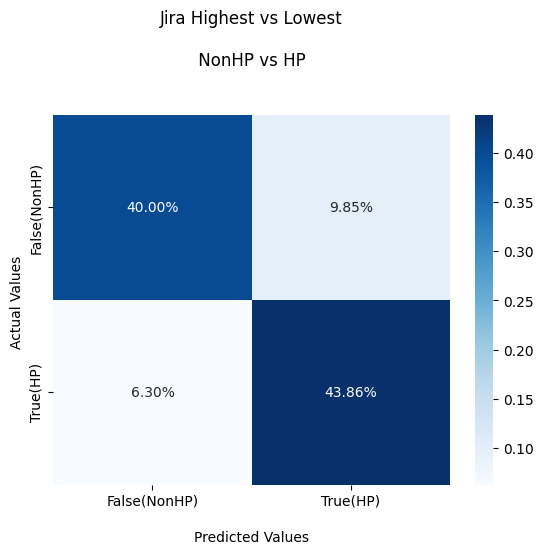

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Jira Highest vs Lowest\n\n NonHP vs HP \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonHP)','True(HP)'])
ax.yaxis.set_ticklabels(['False(NonHP)','True(HP)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [58]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      4859
           1       0.82      0.87      0.84      4889

    accuracy                           0.84      9748
   macro avg       0.84      0.84      0.84      9748
weighted avg       0.84      0.84      0.84      9748



In [59]:
from sklearn.metrics import matthews_corrcoef

# Calculate the Matthew's Correlation Coefficient
mcc = matthews_corrcoef(test_df["label"].values, test_df["pred"].values)
print("Matthew's Correlation Coefficient:", mcc)

Matthew's Correlation Coefficient: 0.6787014078785203


In [60]:
tracker.stop()

0.00134380306030161